In [77]:
import sys
sys.path.insert(0, 'src') 
import os
import json
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import pickle
from tqdm import tqdm

1706160825.70317


TODO:
- Pickle all of the trees that are generated (so we can retroactively do different evals)
- Cache BP embeddings, pass list of embeddings to BERT to generate background distribution
- Increase number of layers to 5
- Zero-shot and few-shot

In [78]:
%reload_ext autoreload
%autoreload 2

In [79]:
import argparse
from tot.methods.bfs import solve
from tot.tasks.bio_name import Bio_Name

In [80]:
args = argparse.Namespace(backend='gpt-4-1106-preview', temperature=0.7, task='bio_name', naive_run=False, prompt_sample=None, method_generate='sample_bionames', method_evaluate='votes_for_bionames', method_select='greedy', n_generate_sample=3, n_evaluate_sample=2, n_select_sample=2)
# args = argparse.Namespace(backend='gpt-3.5-turbo-1106', temperature=0.7, task='bio_name', naive_run=False, prompt_sample=None, method_generate='sample_bionames', method_evaluate='votes_for_bionames', method_select='greedy', n_generate_sample=3, n_evaluate_sample=2, n_select_sample=2)
task = Bio_Name()

In [81]:
# import pandas as pd
# filename = 'src/tot/data/gene_sets/go_terms.csv'
# df = pd.read_csv(filename, header=None, encoding='latin1')
# df.dropna(inplace=True)
# df.columns = ['_', '_', 'genes', 'count', 'process']
# df.head()

In [82]:
# x = df['genes'].tolist()
# y = df['process'].tolist()
# with open('src/tot/data/gene_sets/x.txt', 'w') as f:
#     for el in x:
#         f.write(el + '\n')
        
# with open('src/tot/data/gene_sets/y.txt', 'w') as f:
#     for el in y:
#         f.write(el + '\n')

In [83]:
# import pandas as pd
# filename = 'src/tot/data/gene_sets/1000_selected_go_terms.csv'
# df = pd.read_csv(filename, header=0, encoding='latin1')
# print(df.head())
# df.dropna(inplace=True)
# df.columns = ['_', 'genes', 'count', 'process']
# df.head()

In [84]:
# x = df['genes'].tolist()
# y = df['process'].tolist()
# with open('src/tot/data/gene_sets/x_eval.txt', 'w') as f:
#     for el in x:
#         f.write(el + '\n')
        
# with open('src/tot/data/gene_sets/y_eval.txt', 'w') as f:
#     for el in y:
#         f.write(el + '\n')

In [85]:
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch

SapBERT_tokenizer = AutoTokenizer.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')
SapBERT_model = AutoModel.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')

In [86]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [87]:
def getSentenceEmbedding(sentence, tokenizer, model):
    # Tokenize sentences
    encoded_input = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
        
    # Perform pooling. In this case, mean pooling.
    sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])
    
    return sentence_embedding

In [88]:
# filename = 'src/tot/data/gene_sets/go_terms.csv'
# all_terms_df = pd.read_csv(filename, header=None, encoding='latin1')
# all_terms_df.dropna(inplace=True)
# all_terms_df.columns = ['_', '_', 'genes', 'count', 'process']

In [89]:
# # get embedding for all biological processes
# from tqdm import tqdm
# all_go_terms = all_terms_df['process'].unique().tolist()
# all_go_terms_embeddings_dict = {}
# for term in tqdm(all_go_terms):
#     all_go_terms_embeddings_dict[term] = getSentenceEmbedding(term, SapBERT_tokenizer, SapBERT_model).numpy()

In [90]:
# import pickle
# with open('src/tot/data/gene_sets/all_go_terms_embeddings_dict.pkl', 'wb') as f:
#     pickle.dump(all_go_terms_embeddings_dict, f)

In [91]:
all_go_terms_embeddings_dict = pickle.load(open('src/tot/data/gene_sets/all_go_terms_embeddings_dict.pkl', 'rb'))

In [92]:
# def getSentenceSimilarity(sentence1, sentence2, tokenizer, model, simMetric):
#     if sentence1 in embeddings_dict.keys():
#         sentence1_embedding = embeddings_dict[sentence1]
#     else:
#         sentence1_embedding = getSentenceEmbedding(sentence1, tokenizer, model)
#     if sentence2 not in embeddings_dict.keys():
#         sentence2_embedding = embeddings_dict[sentence2]
#     else:
#         sentence2_embedding = getSentenceEmbedding(sentence2, tokenizer, model)
    
#     if simMetric == "cosine_similarity":
#         sentenceSim = cosine_similarity(sentence1_embedding, sentence2_embedding)[0][0]
#     # ToDo: add other simMetrics
#     #elif simMetric == "cosine_similarity_primitive": # use primitive operations
#    #     sentenceSim = np.dot(sentence1_embedding, sentence2_embedding)/(norm(sentence1_embedding)*norm(sentence2_embedding))
    
#     return sentenceSim, sentence1_embedding, sentence2_embedding

In [93]:
# def similarity_score(x, y):
#     return getSentenceSimilarity(x, y, SapBERT_tokenizer, SapBERT_model, "cosine_similarity")[0]

In [94]:
def similarity_score(pred, label):
    pred_embedding = getSentenceEmbedding(pred, SapBERT_tokenizer, SapBERT_model)
    label_embedding = all_go_terms_embeddings_dict[label]
    similarity_score = cosine_similarity(pred_embedding, label_embedding)[0][0]
    return similarity_score

def similarity_percentile(similarity_score, pred):
    pred_embedding = getSentenceEmbedding(pred, SapBERT_tokenizer, SapBERT_model)
    null_dist = []
    for term in all_go_terms_embeddings_dict.keys():
        term_embedding = all_go_terms_embeddings_dict[term]
        sentenceSim = cosine_similarity(pred_embedding, term_embedding)[0][0]
        null_dist.append(sentenceSim)
    # get similarity percentile
    null_dist = np.array(null_dist)
    # return the fraction of scores that are smaller than the candidate
    percentile = (null_dist < similarity_score).mean()
    return percentile

null distribution of sim scores: random assignment of different pairs of labels
compare the sim score of the answer to true label to null distribution -> p value (sim score greater than 98% of random sim scores for example)
500/1000 had p > .98

In [95]:
def test_example(args, task, idx):
    label = task.get_label(idx)
    final_answer, ys, steps, trie = solve(args, task, idx)
    return final_answer, ys, steps, trie, label


In [96]:
def get_all_candidate_bio_processes(steps):
    candidate_processes = []
    step_count = 0
    for step in steps['steps'][:-1]:
        step_count += 1
        new_ys = [json.loads(step['new_ys'][i]) for i in range(len(step['new_ys']))]
        new_bio_processes = [y['Biological Process'] for y in new_ys]
        candidate_processes.extend(new_bio_processes)
    candidate_processes = list(set(candidate_processes))
    return candidate_processes
    

In [97]:
def get_best_candidate_bio_process(candidate_processes, label):
    scores = [similarity_score(candidate_process, label) for candidate_process in candidate_processes]
    best_candidate_process = candidate_processes[np.argmax(scores)]
    return best_candidate_process, np.max(scores)

In [98]:
from tot.models import *
gpt = partial(gpt, model=args.backend, temperature=args.temperature)
def get_gpt_similarity_score(process1, process2):
    system_message, user_message = task.similarity_prompt_wrap(process1, process2)
    response = gpt(system_message, user_message)
    similarity_score = task.unwrap_similarity(response)
    return similarity_score

In [99]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [100]:
def test_example_wrap(idx, task):
    final_answer, ys, steps, trie, label = test_example(args, task, idx)
    candidate_processes = get_all_candidate_bio_processes(steps)
    best_candidate_process, best_candidate_similarity_score = get_best_candidate_bio_process(candidate_processes, label)
    final_answer_similarity_score = similarity_score(final_answer, label)
    final_answer_similarity_quantile = similarity_percentile(final_answer_similarity_score, final_answer)
    best_candidate_similarity_quantile = similarity_percentile(best_candidate_similarity_score, best_candidate_process)
    print('Index:', idx)
    print('Final answer:', final_answer)
    print('True answer:', label.strip())
    print('Final answer similarity score:', similarity_score(final_answer, label))
    print('Best candidate process:', best_candidate_process)
    print('Best candidate similarity score:', best_candidate_similarity_score)
    print('Final Answer Similarity Quantile:', final_answer_similarity_quantile)
    print('Best Candidate Similarity Quantile:', best_candidate_similarity_quantile)
    print()
    return {'index': idx, 'final answer': final_answer, 'ys': ys, 'steps': steps, 'label': label, 'final answer similarity score': final_answer_similarity_score,'best candidate process': best_candidate_process, 'best similarity score': best_candidate_similarity_score,
            'final answer similarity quantile': final_answer_similarity_quantile, 'best candidate similarity quantile': best_candidate_similarity_quantile, 'trie': trie}

In [113]:
def eval_100(task, save_filename, start_idx=0, stop_idx=100, preload=False):
    if preload:
        results = pickle.load(open(save_filename, 'rb'))
    else:
        results = []
    eval_indices = range(start_idx, stop_idx)
    for idx in tqdm(eval_indices):
        # start = time.time()
        results.append(test_example_wrap(idx, task))
        with open(save_filename, 'wb') as f:
            pickle.dump(results, f)
        # print('Time taken:', time.time() - start)
        print()

In [114]:
args = argparse.Namespace(backend='gpt-4-1106-preview', temperature=0.7, task='bio_name', naive_run=False, prompt_sample=None, method_generate='sample_bionames', method_evaluate='votes_for_bionames', method_select='greedy', n_generate_sample=3, n_evaluate_sample=2, n_select_sample=2)
task_tot = Bio_Name()
save_file = 'results/eval_tot_0_99.pkl'
eval_100(task_tot, save_file, start_idx=50, stop_idx=100, preload=True)

  0%|          | 0/50 [00:00<?, ?it/s]

running 1/5 step
system_message user_message
You are a helpful and knowledgable assistant to a molecular biologist. Respond to questions in JSON format, following this template: {"Answer 1": {"Step": "1", "Biological Process": "<Your first proposed biological process>", "Reason": "<Why did you choose this name?>"},
            "Answer 2": {"Step": "1", "Biological Process": "<Your second proposed biological process>", "Reason": "<Why did you choose this name?>"},
            "Answer 3": {"Step": "1", "Biological Process": "<Your third proposed biological process>", "Reason": "<Why did you choose this name?>"},...}. You are given a set of genes, and your task is to propose a least five high-level biological processes that may be likely to be performed by the system involving expression of these genes.

Biological processes are organized in a hierarchical ontology, and the most general biological processes are at the top of the hierarchy.
Biological processes can have four relations:
1. 

  0%|          | 0/50 [00:21<?, ?it/s]


AuthenticationError: Incorrect API key provided: sk-9plNx***************************************9Zva. You can find your API key at https://platform.openai.com/account/api-keys.

In [76]:
args = argparse.Namespace(backend='gpt-4-1106-preview', temperature=0.7, task='bio_name', naive_run=False, \
                          prompt_sample=None, method_generate='sample_bionames', \
                          method_evaluate='multi_voters', method_select='greedy', n_generate_sample=3, \
                          n_evaluate_sample=2, n_select_sample=2, \
                          source='GO:BP', bio_type="Biological Process",filter_method='sim', filter_size=5, voting_setting=None,\
                          
                         )
            
task_gprofiler = Bio_Name()
save_file = 'results/eval_gprofiler_0_99.pkl'
eval_100(task_gprofiler, save_file, start_idx=50, stop_idx=100, preload=True)

  0%|          | 0/50 [00:00<?, ?it/s]

running 1/5 step


NameError: name 'time' is not defined

In [205]:
import argparse

medagents_config = {'model_name':'gpt-4-1106-preview', \
                    'method':'syn_verif', \
                    'max_attempt_vote':3,\
                    'ans_num':2,\
                    'numerical':True
                   }

tot_config = {'backend':'gpt-4-1106-preview', 'temperature':0.7, 'task':'bio_name', 'naive_run':False, \
              'prompt_sample':None, 'method_generate':'sample_bionames', \
              'method_evaluate':'medagents_w_tools', 'method_select':'greedy', \
              'n_generate_sample':3, 'n_evaluate_sample':2, 'n_select_sample':2, \
              'source':'GO:BP', 'bio_type':"Biological Process",'filter_method':'sim', \
              'filter_size':5, 'voting_setting':None}

args_config = {**medagents_config, **tot_config}
args = argparse.Namespace(**args_config)
task_medagents_gprofiler = Bio_Name()
save_file = 'results/eval_medagents_gprofiler_0_99.pkl'
eval_100(task_medagents_gprofiler, save_file)

  0%|          | 0/100 [00:00<?, ?it/s]

Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  1.0653409957885742
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  1.3909640312194824
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  23.81737208366394
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  19.367439031600952
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  34.58527684211731
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  26.419435024261475
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  13.880903720855713
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  25.659600019454956
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  14.852896928787231
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  47.09683299064636
Generating response for engine:  gpt-4-1106-preview
Finish!
Time taken:  1.97571492

  1%|          | 1/100 [04:17<7:04:39, 257.37s/it]

Index: 0
Final answer: Lipid metabolic process
True answer: positive regulation of intracellular cholesterol transport
Final answer similarity score: 0.27524304
Best candidate process: Lipid metabolic process
Best candidate similarity score: 0.27524304
Final Answer Similarity Quantile: 0.6187981005403635
Best Candidate Similarity Quantile: 0.6187981005403635

Time taken: 257.3694851398468



  1%|          | 1/100 [04:36<7:36:47, 276.84s/it]


KeyboardInterrupt: 

In [29]:
final_ans_count = 0
best_candidate_count = 0
for res in results:
    final_ans_count += int(res['final answer similarity quantile'] >= .98)
    best_candidate_count += int(res['best candidate similarity quantile'] >= .98)

In [30]:
final_ans_count, best_candidate_count

(8, 15)

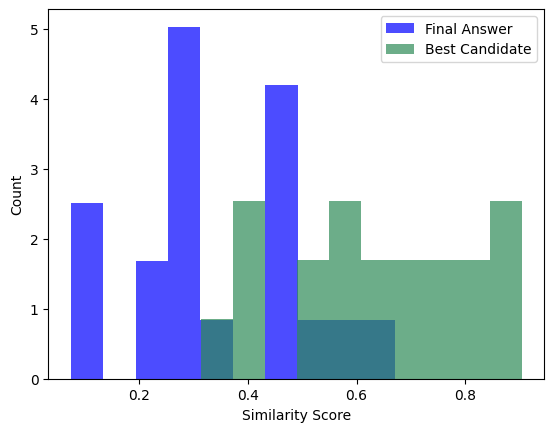

In [34]:
final_ans_scores = []
best_candidate_scores = []
for res in results:
    final_ans_scores.append(res['final answer similarity score'])
    best_candidate_scores.append(res['best similarity score'])

import matplotlib.pyplot as plt
plt.hist(final_ans_scores, alpha=0.7, label='Final Answer', color='blue', density=True)
plt.hist(best_candidate_scores, alpha=0.7, label='Best Candidate', color='seagreen', density=True)
plt.xlabel('Similarity Score')
plt.ylabel('Count')
plt.legend(['Final Answer', 'Best Candidate'])
plt.show()

In [28]:
with open('results/eval_tot_0_99.pkl', 'rb') as f:
    data = pickle.load(f)

In [50]:
tot_data = pickle.load(open('results/eval_tot_0_99.pkl', 'rb'))
gprofiler_data = pickle.load(open('results/eval_gprofiler_0_99.pkl', 'rb'))
medagents_data = pickle.load(open('results/eval_medagents_gprofiler_0_99.pkl', 'rb'))

In [51]:
results_final_ans = []
results_best_candidate = []
for i in range(50):
    if len(tot_data) > i:
        tot_final_ans = tot_data[i]['final answer']
        tot_best_candidate = tot_data[i]['best candidate process']
        tot_final_ans_score = tot_data[i]['final answer similarity quantile']
        tot_best_candidate_score = tot_data[i]['best candidate similarity quantile']
    else:
        tot_final_ans = None
        tot_best_candidate = None
        tot_final_ans_score = None
        tot_best_candidate_score = None
    if len(gprofiler_data) > i:
        gprofiler_final_ans = gprofiler_data[i]['final answer']
        gprofiler_best_candidate = gprofiler_data[i]['best candidate process']
        gprofiler_final_ans_score = gprofiler_data[i]['final answer similarity quantile']
        gprofiler_best_candidate_score = gprofiler_data[i]['best candidate similarity quantile']
    else:
        gprofiler_final_ans = None
        gprofiler_best_candidate = None
        gprofiler_final_ans_score = None
        gprofiler_best_candidate_score = None
    if len(medagents_data) > i:
        medagents_final_ans = medagents_data[i]['final answer']
        medagents_best_candidate = medagents_data[i]['best candidate process']
        medagents_final_ans_score = medagents_data[i]['final answer similarity quantile']
        medagents_best_candidate_score = medagents_data[i]['best candidate similarity quantile']
    else:
        medagents_final_ans = None
        medagents_best_candidate = None
        medagents_final_ans_score = None
        medagents_best_candidate_score = None


    results_final_ans.append({'tot': tot_final_ans_score, 'gprofiler': gprofiler_final_ans_score, 'medagents': medagents_final_ans_score})
    results_best_candidate.append({'tot': tot_best_candidate_score, 'gprofiler': gprofiler_best_candidate_score, 'medagents': medagents_best_candidate_score})


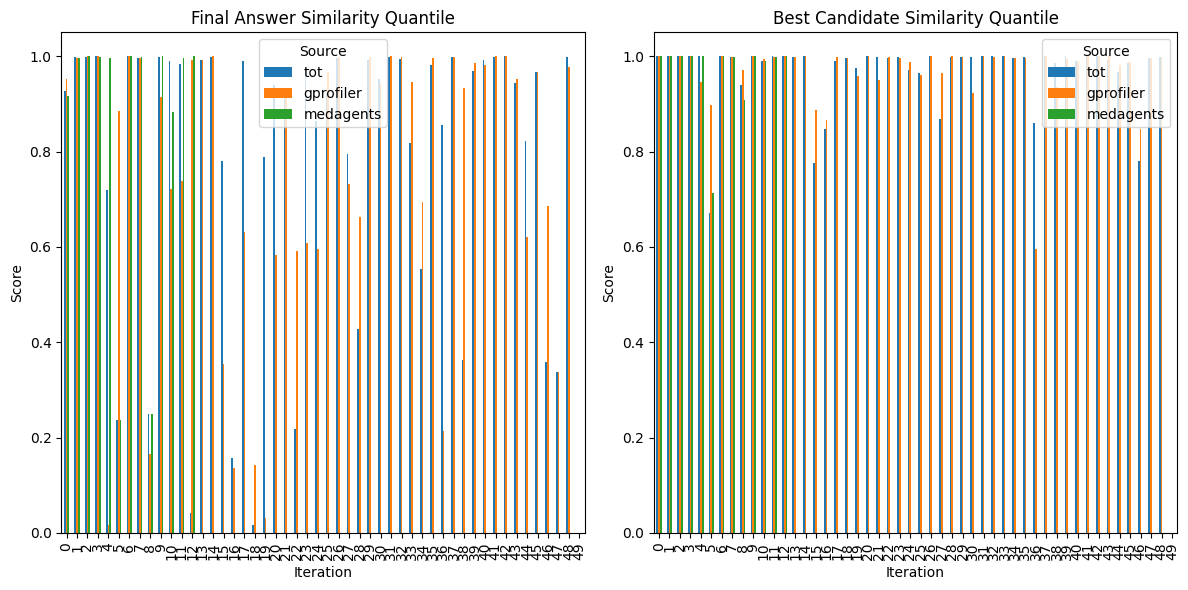

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming results_final_ans and results_best_candidate are already populated as per your code
df_final_ans = pd.DataFrame(results_final_ans)
df_best_candidate = pd.DataFrame(results_best_candidate)

# Replace None with NaN for proper handling in plots
df_final_ans = df_final_ans.fillna(value=np.nan)
df_best_candidate = df_best_candidate.fillna(value=np.nan)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df_final_ans.plot(kind='bar', ax=plt.gca())
plt.title('Final Answer Similarity Quantile')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.legend(title='Source')

plt.subplot(1, 2, 2)
df_best_candidate.plot(kind='bar', ax=plt.gca())
plt.title('Best Candidate Similarity Quantile')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.legend(title='Source')

plt.tight_layout()
plt.show()


In [53]:
import pandas as pd

# Assuming results_final_ans and results_best_candidate are already populated as per your code
df_final_ans = pd.DataFrame(results_final_ans)
df_best_candidate = pd.DataFrame(results_best_candidate)

# Replace None with NaN for proper handling in calculations
df_final_ans = df_final_ans.fillna(value=np.nan)
df_best_candidate = df_best_candidate.fillna(value=np.nan)

# Calculate means
mean_final_ans = df_final_ans.iloc[:50].mean()
mean_best_candidate = df_best_candidate.iloc[:50].mean()

print("Mean Final Answer Similarity Quantile:")
print(mean_final_ans)
print("\nMean Best Candidate Similarity Quantile:")
print(mean_best_candidate)


Mean Final Answer Similarity Quantile:
tot          0.792192
gprofiler    0.766599
medagents    0.866849
dtype: float64

Mean Best Candidate Similarity Quantile:
tot          0.969622
gprofiler    0.971513
medagents    0.969480
dtype: float64


In [54]:
import pandas as pd
import numpy as np

# Assuming results_final_ans and results_best_candidate are already populated as per your code
df_final_ans = pd.DataFrame(results_final_ans)
df_best_candidate = pd.DataFrame(results_best_candidate)

# Replace None with NaN for proper handling in calculations
df_final_ans = df_final_ans.fillna(value=np.nan)
df_best_candidate = df_best_candidate.fillna(value=np.nan)

# Proportion of scores > 0.98
proportion_final_ans_above_98 = (df_final_ans.iloc[:50] > 0.98).sum() / 50
proportion_best_candidate_above_98 = (df_best_candidate.iloc[:50] > 0.98).sum() / 50

print("Proportion of Final Answer Similarity Scores > 0.98:")
print(proportion_final_ans_above_98)
print("\nProportion of Best Candidate Similarity Scores > 0.98:")
print(proportion_best_candidate_above_98)


Proportion of Final Answer Similarity Scores > 0.98:
tot          0.42
gprofiler    0.36
medagents    0.18
dtype: float64

Proportion of Best Candidate Similarity Scores > 0.98:
tot          0.76
gprofiler    0.72
medagents    0.22
dtype: float64


# Analysis

In [68]:
gprofiler_data[0]
print(json.loads(gprofiler_data[0]['ys'][0]))

{'Step': '5', 'Relation': 'has part', 'Reason': 'Clathrin-mediated endocytosis is a specific mechanism by which LDL cholesterol endocytosis occurs. The gene LDLRAP1 is important in the formation of clathrin-coated vesicles which are essential for the internalization of LDL particles.', 'Biological Process': 'Clathrin-mediated endocytosis of LDL'}


In [74]:
for i in range(1, 4):
    dic = gprofiler_data[i]
    genes = task.get_input(dic['index'])
    final_ans = dic['final answer']
    final_ans_similarity_score = dic['final answer similarity score']
    final_ans_similarity_quantile = dic['final answer similarity quantile']
    label = dic['label']
    trie = dic['trie']
    dot = trie.visualize()
    dot.render('jiawei_examples/trie_visualization_{}'.format(i), format='png')
    print('Genes:', genes)
    print('Final answer:', final_ans)
    print('Final answer similarity score:', final_ans_similarity_score)
    print('Final answer similarity quantile:', final_ans_similarity_quantile)
    print('True answer:', label)

    print()
    

Genes: NOD1 HLA-DRA CLEC4A HLA-DRB1 CCL21 NOD2 CCL19 SLC11A1 HLA-DRB3 CCR7 CD68 FCGR2B THBS1 FGL2 CD74
Final answer: positive regulation of MHC class II biosynthesis
Final answer similarity score: 0.45106328
Final answer similarity quantile: 0.9953332241689864
True answer: dendritic cell antigen processing and presentation

Genes: OGG1 ERCC5 XPA ERCC4 NTHL1
Final answer: DNA damage recognition in GG-NER
Final answer similarity score: 0.71089345
Final answer similarity quantile: 0.9995906336990339
True answer: nucleotide-excision repair, DNA incision

Genes: SLC7A11 SLC25A39 SLC26A6 ABCB9 SLC15A4 ABCC5 CDH17 SLC15A3 ABCC4 SLC13A3 GJA1 SLC15A1 SLC15A2 ABCC1 CA2
Final answer: Brush border oligopeptide translocation
Final answer similarity score: 0.69717884
Final answer similarity quantile: 0.9997543802194203
True answer: oligopeptide transmembrane transport



In [115]:
tot_data[0]

{'index': 0,
 'final answer': 'Clathrin-mediated LDL receptor endocytosis',
 'ys': ['{"Step": "5", "Relation": "part of", "Reason": "The biological process of clathrin-mediated endocytosis is a crucial step in LDL receptor recycling, as it is the mechanism by which LDL receptors are internalized along with LDL particles. The LDLRAP1 gene is known to interact with components of the clathrin-mediated endocytosis pathway, aiding in the internalization process.", "Biological Process": "Clathrin-mediated LDL receptor endocytosis"}',
  '{"Step": "5", "Relation": "has part", "Reason": "Intracellular cholesterol transport is a critical component of cellular cholesterol homeostasis, which involves the distribution of cholesterol within the cell to various organelles. The gene SCP2 (Sterol Carrier Protein 2) is known to be involved in the intracellular transport of lipids, including cholesterol.", "Biological Process": "Intracellular cholesterol transport"}'],
 'steps': {'steps': [{'step': 0,
  

In [151]:
def get_terms_by_layer(trie):
    layers = {}
    layer_num = 1
    root = trie.root
    queue = [root]
    while queue:
        children = []
        layer = []
        for node in queue:
            if node.children:
                children.extend(node.children.values())
                layer.extend(node.children.keys())
        if layer:
            layers[layer_num] = layer
            queue = children
            layer_num += 1
        else:
            break
    return layers

In [177]:
tot_data_by_layer = {}
for idx in range(0, 50):
    print(idx)
    example_dic = {}
    tot_data_dict = tot_data[idx]
    genes = task.get_input(idx)
    num_genes = len(genes.split(' '))
    label = tot_data_dict['label']
    trie = tot_data_dict['trie']
    layers = get_terms_by_layer(trie)
    best_answer = tot_data_dict['best candidate process']
    example_dic = {'genes': genes, 'num_genes': num_genes, 'label': label, 'best answer': best_answer, 'layers': {}}
    for layer_num, terms in layers.items():
        layer_dic = {}
        for term in terms:
            term_sim_score = similarity_score(term, label)
            term_sim_quantile = similarity_percentile(term_sim_score, term)
            layer_dic[term] = {'similarity score': term_sim_score, 'similarity quantile': term_sim_quantile}
        example_dic['layers'][layer_num] = layer_dic
    tot_data_by_layer[idx] = example_dic


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


In [190]:
len(tot_data_by_layer.keys())

49

In [179]:
quantiles_by_layer = {}
for idx, example_dic in tot_data_by_layer.items():
    for layer_num, terms in example_dic['layers'].items():
        for term, term_dic in terms.items():
            quantile = term_dic['similarity quantile']
            if layer_num not in quantiles_by_layer.keys():
                quantiles_by_layer[layer_num] = []
            quantiles_by_layer[layer_num].append(quantile)

In [180]:
# get average quantile by layer
avg_quantiles_by_layer = {}
for layer_num, quantiles in quantiles_by_layer.items():
    avg_quantiles_by_layer[layer_num] = np.mean(quantiles)
avg_quantiles_by_layer

{1: 0.5635642827623926,
 2: 0.7131687508331899,
 3: 0.7710751062320068,
 4: 0.7639537638347522,
 5: 0.7559715429930276}

In [185]:
proportion_quantiles_above_98_by_layer = {}
for layer_num, quantiles in quantiles_by_layer.items():
    proportion_quantiles_above_98_by_layer[layer_num] = (np.array(quantiles) > 0.98).mean()
proportion_quantiles_above_98_by_layer

{1: 0.11564625850340136,
 2: 0.21189591078066913,
 3: 0.30141843971631205,
 4: 0.30584192439862545,
 5: 0.3230240549828179}

In [194]:
# find best answer location
best_answer_location = [] # first instance
num_genes = []
for idx, example_dic in tot_data_by_layer.items():
    found = False
    best_answer = tot_data[idx]['best candidate process']
    for layer_num, terms in example_dic['layers'].items():
        if found:
            break
        for term, term_dic in terms.items():
            if term == example_dic['best answer']:
                best_answer_location.append(layer_num)
                num_genes.append(example_dic['num_genes'])
                found = True
                break
            

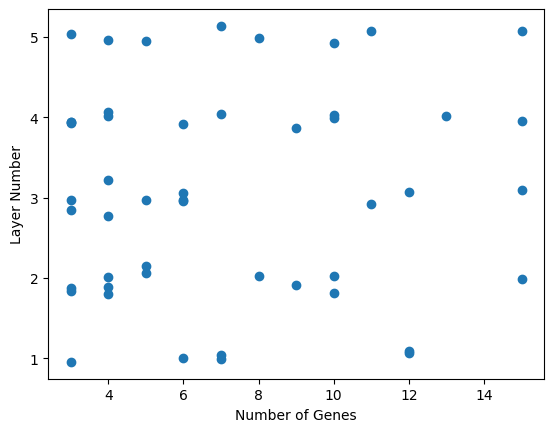

In [195]:
# plot best answer location by number of genes
import matplotlib.pyplot as plt
new_best_answer_location = [location + np.random.normal(0, 0.1) for location in best_answer_location]
plt.scatter(num_genes, new_best_answer_location)
plt.xlabel('Number of Genes')
plt.ylabel('Layer Number')
plt.show()


In [202]:
# pd.Series(num_genes).value_counts()
len(num_genes)

12

In [203]:
len(tot_data_by_layer)

49

In [218]:
# similarity quantile by number of genes
final_ans_quantile = []
num_genes = []
best_ans_quantile = []
for idx, example_dic in tot_data_by_layer.items():
    # print(idx)
    best_ans_quantile .append(tot_data[idx]['best candidate similarity quantile'])
    final_ans_quantile.append(tot_data[idx]['final answer similarity quantile'])
    num_genes.append(example_dic['num_genes'])
    

In [219]:
len(final_ans_quantile)

49

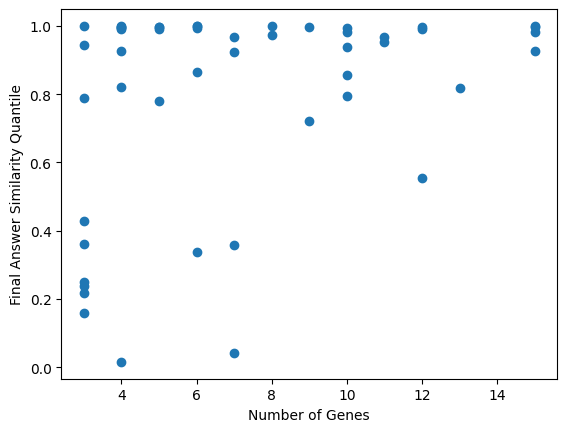

In [214]:
# plot final answer quantile by number of genes
import matplotlib.pyplot as plt
plt.scatter(num_genes, final_ans_quantile)
plt.xlabel('Number of Genes')
plt.ylabel('Final Answer Similarity Quantile')
plt.show()

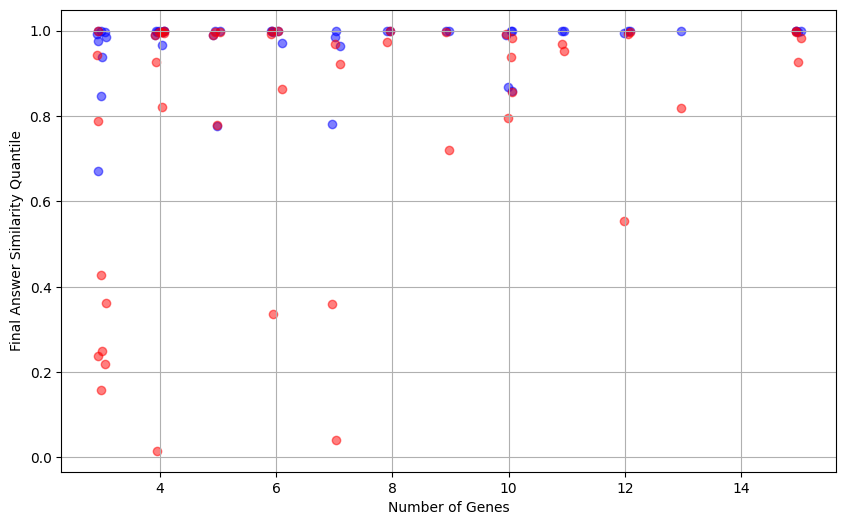

In [223]:


# Jitter the 'num_genes' data to help prevent overlap
jitter_strength = 0.1  # adjust this value as needed
jittered_num_genes = num_genes + np.random.uniform(-jitter_strength, jitter_strength, size=len(num_genes))

# Create a scatter plot with jittered data and semi-transparent points
plt.figure(figsize=(10, 6))
plt.scatter(jittered_num_genes, best_ans_quantile, alpha=0.5, c='blue')  # adjust alpha for transparency
plt.scatter(jittered_num_genes, final_ans_quantile, alpha=0.5, c='red')  # adjust alpha for transparency
plt.xlabel('Number of Genes')
plt.ylabel('Final Answer Similarity Quantile')
plt.grid(True)
plt.show()


In [226]:
quantiles_by_layer

{1: [0.5272637956443426,
  0.5091698051416408,
  0.7555264450630425,
  0.8014573440314393,
  0.9983625347961356,
  0.5465858850499427,
  0.13820206320615686,
  0.9983625347961356,
  0.3835762240052399,
  0.6507286720157197,
  0.5261175700016375,
  0.9765842475847388,
  0.9830522351400033,
  0.5726215817913869,
  0.5248894710987392,
  0.9546422138529557,
  0.5349598821025053,
  0.3471426232192566,
  0.8179957425904699,
  0.4682331750450303,
  0.7372687080399541,
  0.2836908465695104,
  0.3474701162600295,
  0.9954150974291797,
  0.9277877845095792,
  0.7934337645325037,
  0.7843458326510562,
  0.03438676928115277,
  0.08105452759128869,
  0.5947273620435566,
  0.9509579171442607,
  0.8061241198624529,
  0.348780088423121,
  0.6361552317013264,
  0.7998198788275749,
  0.44530866219092846,
  0.6318978221712789,
  0.9517766497461929,
  0.39880465040117896,
  0.8386278041591616,
  0.716472899950876,
  0.7279351563779269,
  0.9354019977075487,
  0.7792696905190765,
  0.8016210905518257,
  0.

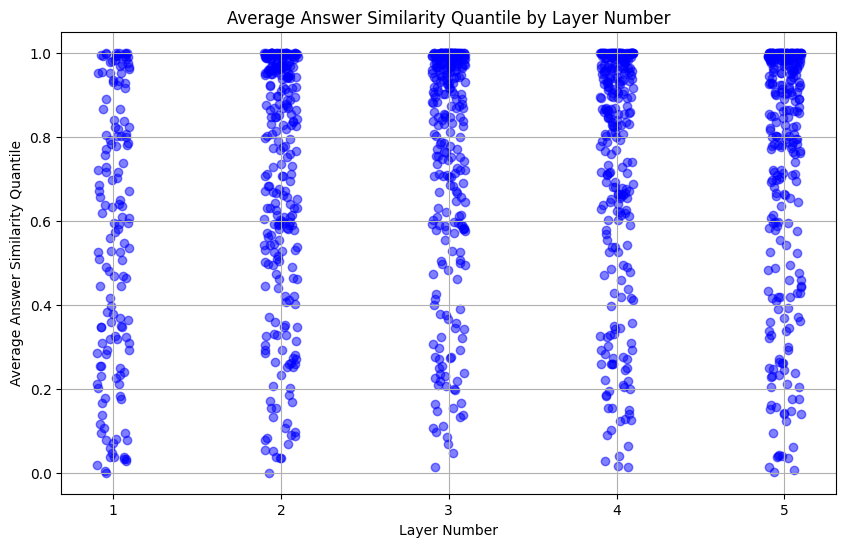

In [229]:
# Prepare the lists for plotting
layer_nums = []
quantiles = []
for layer_num, quantile_lst in quantiles_by_layer.items():
    for quantile in quantile_lst:
        layer_nums.append(layer_num)
        quantiles.append(quantile)



# Since layer numbers are typically discrete, you may want to jitter them slightly to see if any are overlapping
jitter_strength = 0.1  # adjust this value as needed
jittered_layer_nums = np.array(layer_nums) + np.random.uniform(-jitter_strength, jitter_strength, size=len(layer_nums))

# Now, create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(jittered_layer_nums, quantiles, alpha=0.5, color='blue')  # Choose a color you prefer
plt.xlabel('Layer Number')
plt.ylabel('Average Answer Similarity Quantile')
plt.title('Average Answer Similarity Quantile by Layer Number')
plt.grid(True)
plt.show()

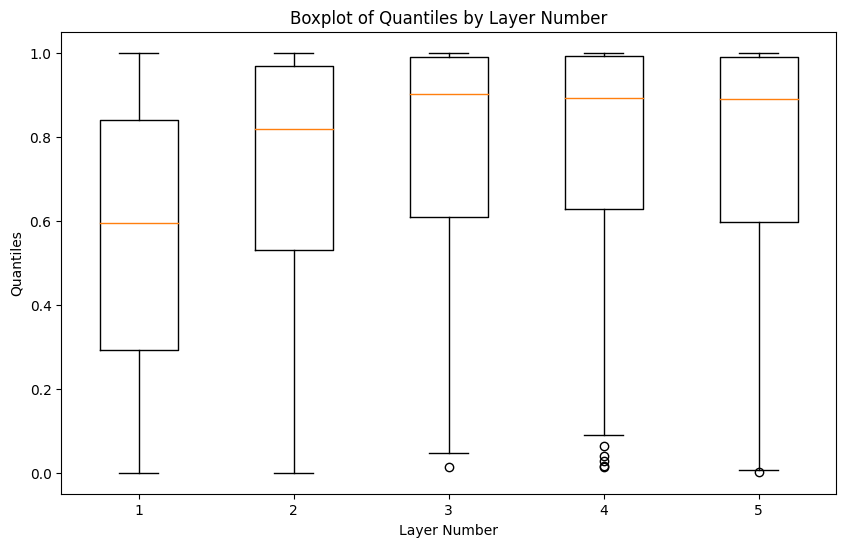

In [231]:
# Now create a box plot
plt.figure(figsize=(10, 6))

# Group the quantiles by layer numbers
layer_groups = [[] for _ in range(max(layer_nums) + 1)]  # create a list of lists for groups
for num, quantile in zip(layer_nums, quantiles):
    layer_groups[num].append(quantile)

# Remove the empty first group if layer numbers start from 1
if layer_nums[0] == 1:
    layer_groups = layer_groups[1:]

# Create the box plot
plt.boxplot(layer_groups)
plt.xlabel('Layer Number')
plt.ylabel('Quantiles')
plt.title('Boxplot of Quantiles by Layer Number')
plt.grid(False)
plt.show()

In [237]:
# select best quantile by layer
best_quantile_by_layer = {}
for idx, example_dic in tot_data_by_layer.items():
    for layer_num, terms in example_dic['layers'].items():
        if layer_num not in best_quantile_by_layer.keys():
            best_quantile_by_layer[layer_num] = []
        layer_quantiles = []
        for term, term_dic in terms.items():
            quantile = term_dic['similarity quantile']
            layer_quantiles.append(quantile)
        best_quantile_by_layer[layer_num].append(np.max(layer_quantiles))


In [240]:
best_quantiles = []
layer_nums = []
for layer_num, quantile_lst in best_quantile_by_layer.items():
    for quantile in quantile_lst:
        layer_nums.append(layer_num)
        best_quantiles.append(quantile)

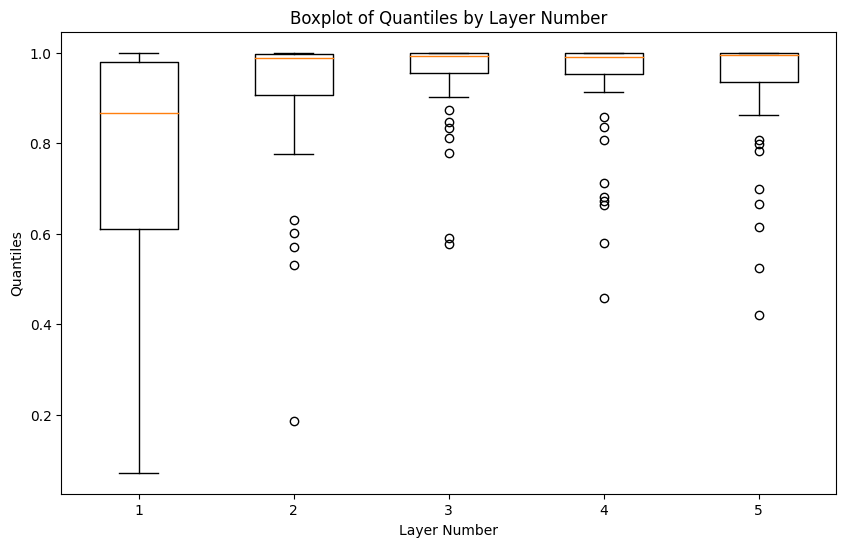

In [241]:
# Now create a box plot
plt.figure(figsize=(10, 6))

# Group the quantiles by layer numbers
layer_groups = [[] for _ in range(max(layer_nums) + 1)]  # create a list of lists for groups
for num, quantile in zip(layer_nums, best_quantiles):
    layer_groups[num].append(quantile)

# Remove the empty first group if layer numbers start from 1
if layer_nums[0] == 1:
    layer_groups = layer_groups[1:]

# Create the box plot
plt.boxplot(layer_groups)
plt.xlabel('Layer Number')
plt.ylabel('Quantiles')
plt.title('Boxplot of Quantiles by Layer Number')
plt.grid(False)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categor

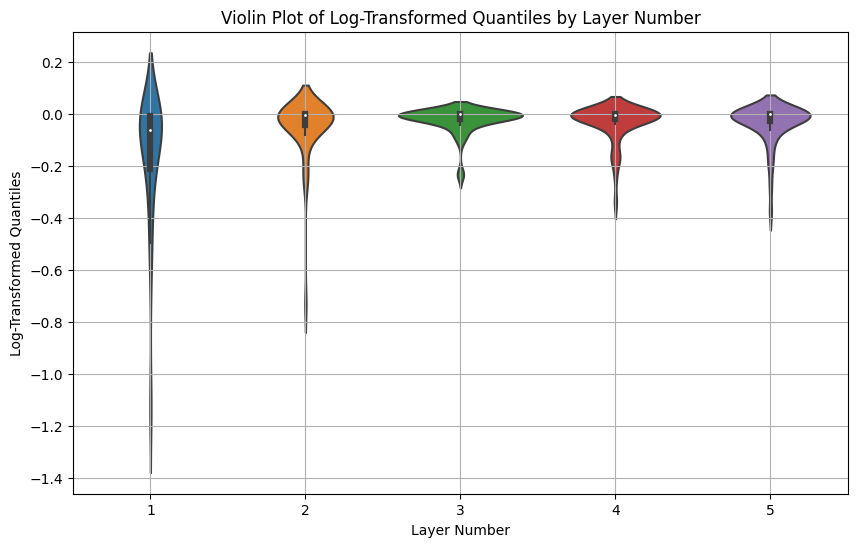

In [243]:
transformed_quantiles = np.log10(np.array(best_quantiles) + 1e-6)

# Now create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x=layer_nums, y=transformed_quantiles)
plt.xlabel('Layer Number')
plt.ylabel('Log-Transformed Quantiles')
plt.title('Violin Plot of Log-Transformed Quantiles by Layer Number')
plt.grid(True)
plt.show()